# Distances
This notebook computes various distances as a function of redshift, and can also do as a function of age of the Universe.

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline
plt.rc("text", usetex=True) #Comment this if LaTeX not installed
plt.rc("font", size=14, family='serif')

Text(0,0.5,'$E(z|\\Omega_m=0.3)$')

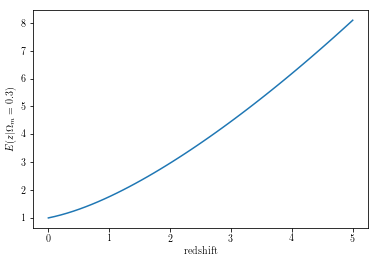

In [2]:
#Define E(z) in the most general way
def calc_Ez(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    if Omega_L is None:
        Omega_L = 1.- Omega_m - Omega_k
    z_plus_1 = 1.+z
    return np.sqrt(Omega_m*z_plus_1**3 + Omega_k*z_plus_1**2 + Omega_L*z_plus_1**(3.*(1.+w)))

z = np.linspace(0,5)
Ez = calc_Ez(z, 0.3)
plt.plot(z, Ez)
plt.xlabel("redshift")
plt.ylabel(r"$E(z|\Omega_m=0.3)$")

In [3]:
#Hubble distance
Hubble_distance = 3000. #Mpc/h
Hubble_time = 9.78 #Gyr/h

Text(0,0.5,'Comoving Distance$(z|\\Omega_m=0.3)\\ [h^{-1}{\\rm Mpc}]$')

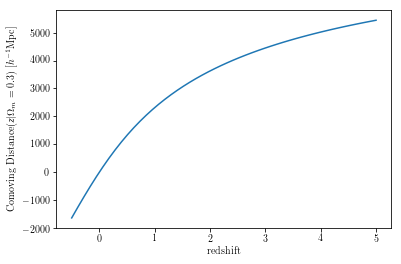

In [4]:
def calc_comoving_distance(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    def integrand(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
        return 1./calc_Ez(z, Omega_m, Omega_L, Omega_k, w)
    z = np.atleast_1d(z)
    return Hubble_distance*np.array([quad(integrand,0,zi, args=(Omega_m, Omega_L, Omega_k, w))[0] for zi in z])

z = np.linspace(-0.5,5)
Dc = calc_comoving_distance(z, 0.3)
plt.plot(z, Dc)
plt.xlabel("redshift")
plt.ylabel(r"Comoving Distance$(z|\Omega_m=0.3)\ [h^{-1}{\rm Mpc}]$")

In [5]:
def calc_transverse_comoving_distance(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    Dc = calc_comoving_distance(z, Omega_m, Omega_L, Omega_k, w)
    if Omega_k == 0:
        return Dc
    else:
        sqOk = np.fabs(np.sqrt(Omega_k))
        if Omega_k < 0:
            return Hubble_distance/sqOk*np.sin(sqOk*Dc/Hubble_distance)
        elif Omega_k > 0:
            return Hubble_distance/sqOk*np.sinh(sqOk*Dc/Hubble_distance)
        else:
            raise Exception("Not implemented yet.")
    raise Exception("This shouldn't have been receached.")

In [6]:
def calc_angular_diameter_distance(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    return calc_transverse_comoving_distance(z, Omega_m, Omega_L, Omega_k, w)/(1+z)

In [7]:
def calc_luminosity_distance(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    return (1+z)*calc_transverse_comoving_distance(z, Omega_m, Omega_L, Omega_k, w)

def calc_distance_modulus(z, H0, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    DL = calc_luminosity_distance(z, Omega_m, Omega_L, Omega_k, w) #Mpc/h
    return 5*(np.log10(DL) + 7 - np.log10(H0)) #Note: the unit conversion

In [8]:
def calc_comoving_volume_element(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    DA = calc_angular_diameter_distance(z, Omega_m, Omega_L, Omega_k, w)
    Ez = calc_Ez(z, Omega_m, Omega_L, Omega_k, w)
    return Hubble_distance * (1+z)**2 * DA**2/Ez

def calc_physical_volume_element(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    return calc_comoving_volume_element(z, Omega_m, Omega_L, Omega_k, w)/(1+z)**3

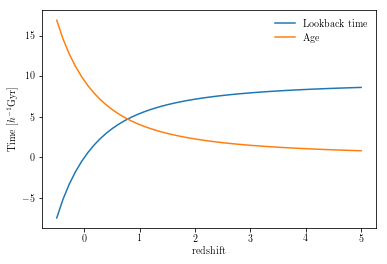

In [9]:
def calc_lookback_time(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    def integrand(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
        return 1./((1+z)*calc_Ez(z, Omega_m, Omega_L, Omega_k, w))
    z = np.atleast_1d(z)
    return Hubble_time * np.array([quad(integrand, 0, zi, args=(Omega_m, Omega_L, Omega_k, w))[0] for zi in z])

def calc_age(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
    def integrand(z, Omega_m, Omega_L=None, Omega_k=0, w=-1):
        return 1./((1+z)*calc_Ez(z, Omega_m, Omega_L, Omega_k, w))
    z = np.atleast_1d(z)
    return Hubble_time * np.array([quad(integrand, zi, np.inf, args=(Omega_m, Omega_L, Omega_k, w))[0] for zi in z])

z = np.linspace(-0.5,5)
Lt  = calc_lookback_time(z, 0.3)#/Hubble_time
Age = calc_age(z, 0.3)#/Hubble_time
plt.plot(z, Lt, label='Lookback time')
plt.plot(z, Age, label='Age')
plt.xlabel("redshift")
plt.ylabel(r"Time $[h^{-1}{\rm Gyr}]$")
plt.legend(loc=0, frameon=False)

# Figure 1
The first real figure will show the average distance between galaxies (angular diameter distance at 1 degree) vs. lookback time for a few different cosmologies with $w=-1$.

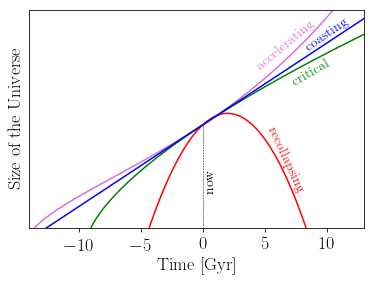

In [12]:
#A function to add SNIa data to a plot
def add_datapoints(ax, spline):
    #Spline is time(redshifts)
    data = pd.read_table("SCPUnion2.1_mu_vs_z.txt", skiprows=4, delim_whitespace=True)
    zs = np.array(data.values[:,1], dtype='float64')
    sfs = 1./(1+zs) #scale factors
    inds = (sfs < 0.85)
    mu = np.array(data.values[inds,2], dtype='float64')
    mue = data.values[inds,3]
    pe = mue/mu
    Lt = spline(mu)
    ax.scatter(Lt, sfs[inds], c='k', s=2, marker='.')
    return

plt.rc("font", size=18)
#Cosmologies [Omega_m, Omega_L, Omega_k]
cosmologies = [[0.25, 0.75, 0],
               [1., 0, 0],]
#               [2, -0.5, -1]]
h = 0.7 #Hubble constant
colors = ['orchid', 'green', 'red']

z = np.linspace(-0.5,10, 1000)
scale_factors = 1./(1+z)
for i,cosmo in enumerate(cosmologies):
    Om, OL, Ok = cosmo
    Age_today = calc_age(0, Om, OL, Ok)
    Lt = (calc_age(z, Om, OL, Ok) - Age_today)/h
    #DA = calc_Ez(z, Om, OL, Ok)
    #DA = calc_comoving_distance(z, Om, OL, Ok)/Hubble_distance
    #DA = calc_transverse_comoving_distance(z, Om, OL, Ok)/Hubble_distance
    #DA = calc_angular_diameter_distance(z, Om, OL, Ok)/Hubble_distance
    #DA = (calc_comoving_volume_element(z, Om, OL, Ok)/Hubble_distance**3)**(1./3.)
    #DA = (calc_physical_volume_element(z, Om, OL, Ok)/Hubble_distance**3)**(1./3.)
    DA = scale_factors
    plt.plot(Lt, DA, c=colors[i])
    #Add data if we have the accelerating cosmology
    if i == 0:
        z2 = np.linspace(0.01,10)
        Lt2 = Lt = (calc_age(z2, Om, OL, Ok) - Age_today)/h
        DM = calc_distance_modulus(z2, h*100, Om, OL, Ok)
        spline = IUS(DM, Lt2)
        #add_datapoints(plt.gca(), spline)
        #break
#plt.ylim(np.log(.001),np.log(2))
t_collapse = np.linspace(-14,13,1000)
a_collapse = -(1./40.)*t_collapse**2 + (2./20.)*t_collapse + 1
plt.plot(t_collapse, a_collapse, c='red')

t_coasting = np.linspace(-14,13)
a_coasting = t_coasting/14. + 1
plt.plot(t_coasting, a_coasting, c='b')
plt.ylim(0.1,2)
plt.xlim(-14, 13)
plt.plot([0,0],[0.1,1], c='k', ls='--', lw=0.5)
fs = 14
plt.text(0,.5,"now",rotation=90, size=fs)
plt.text(5,.9,"recollapsing",color='r',rotation=-65, size=fs)
plt.text(7,1.5,"critical", color='g', rotation=30, size=fs)
plt.text(8,1.87,"coasting", color='b', rotation=35, size=fs)
plt.text(4.1,1.85,"accelerating", color='orchid', rotation=40, size=fs)
plt.xlabel(r"Time [Gyr]")
plt.ylabel(r"Size of the Universe")
plt.yticks([])
plt.savefig("age_vs_size_noSNIa.png", dpi=300, bbox_inches='tight')